## Definições iniciais
Esta seção compõe a base para a execução das análises deste notebook. As funções de manipulação de dados foram todas definidas aqui para apenas serem utilizadas na parte de visualização, reduzindo a quantidade de código onde as conclusões são mais importantes.

Como objetivo final, este estudo busca entender o racional de alocação de UBS por um estado. Descoberta a lógica, segue-se para a crítica da mesma, com a possível criação de um modelo capaz de executar com eficiência uma alocação de nova UBS.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
base_path = "/media/bruno/Arquivos/Desenvolvimento/UBS"
def get_dataset() -> pd.DataFrame:
    # Carrega base bruta
    dataset = pd.read_csv(f"{base_path}/data/dataset.csv")

    # Utiliza aproximação de triângulo retângulo e milha náutica para cálculo das
    # distâncias das unidades até o centro da cidade, uma vez que as distâncias são
    # pequenas (menores que 800 NM) e não é necessário implementar Haversine.
    conversion = 60 * 1.852
    dataset["DISTANCE"] = np.sqrt(
        np.power((dataset["CITY_LAT"] - dataset["UBS_LAT"]) * conversion, 2)
            + np.power((dataset["CITY_LON"] - dataset["UBS_LON"]) * conversion, 2)
    )

    return dataset.query("UF != 'DF'")


def sort_with_category(x: list, y: list) -> None:
    for i in range(0, len(y)):
        for j in range(i + 1, len(y)):
            if y[j] > y[i]:
                y[i], y[j] = y[j], y[i]
                x[i], x[j] = x[j], x[i]


def get_color(key) -> str:
    if key == "black":
        return "#808080"
    elif key == "focus":
        return "#f3e79d"

Uma hipótese inicial era de que a alocação de UBS se dava em função da população e/ou PIB. Assim, SP deveria de apresentar uma quantidade absurdamente maior do que os demais estados, mas isto não é verificado nem na quantidade absoluta (Figura 1) e nem na quantidade de UBS por cidade (Figura 2). Por outro lado, a quantidade de UBS parece ser mais relacionada com a quantidade de cidades (Figura 3), sobrepondo a influência do número de habitantes.

Essa relação entre quantidade de cidades e quantidade de UBS fica mais visível pelo formato das distribuições, onde o decrescimento ocorre de maneira menos acentuada, quando comparada com as distribuições de PIB e população. Tal observação possui certa lógica, já que o objetivo do governo é alocar UBS nas cidades, estados com mais cidades deveriam de ter mais UBS.

Desta análise inicial, fica como observação uma possível menor relação entre população e quantidade de UBS. Para ratificar ou não a hipótese, a próxima abordagem faz a tradução de correlação em valores numéricos.

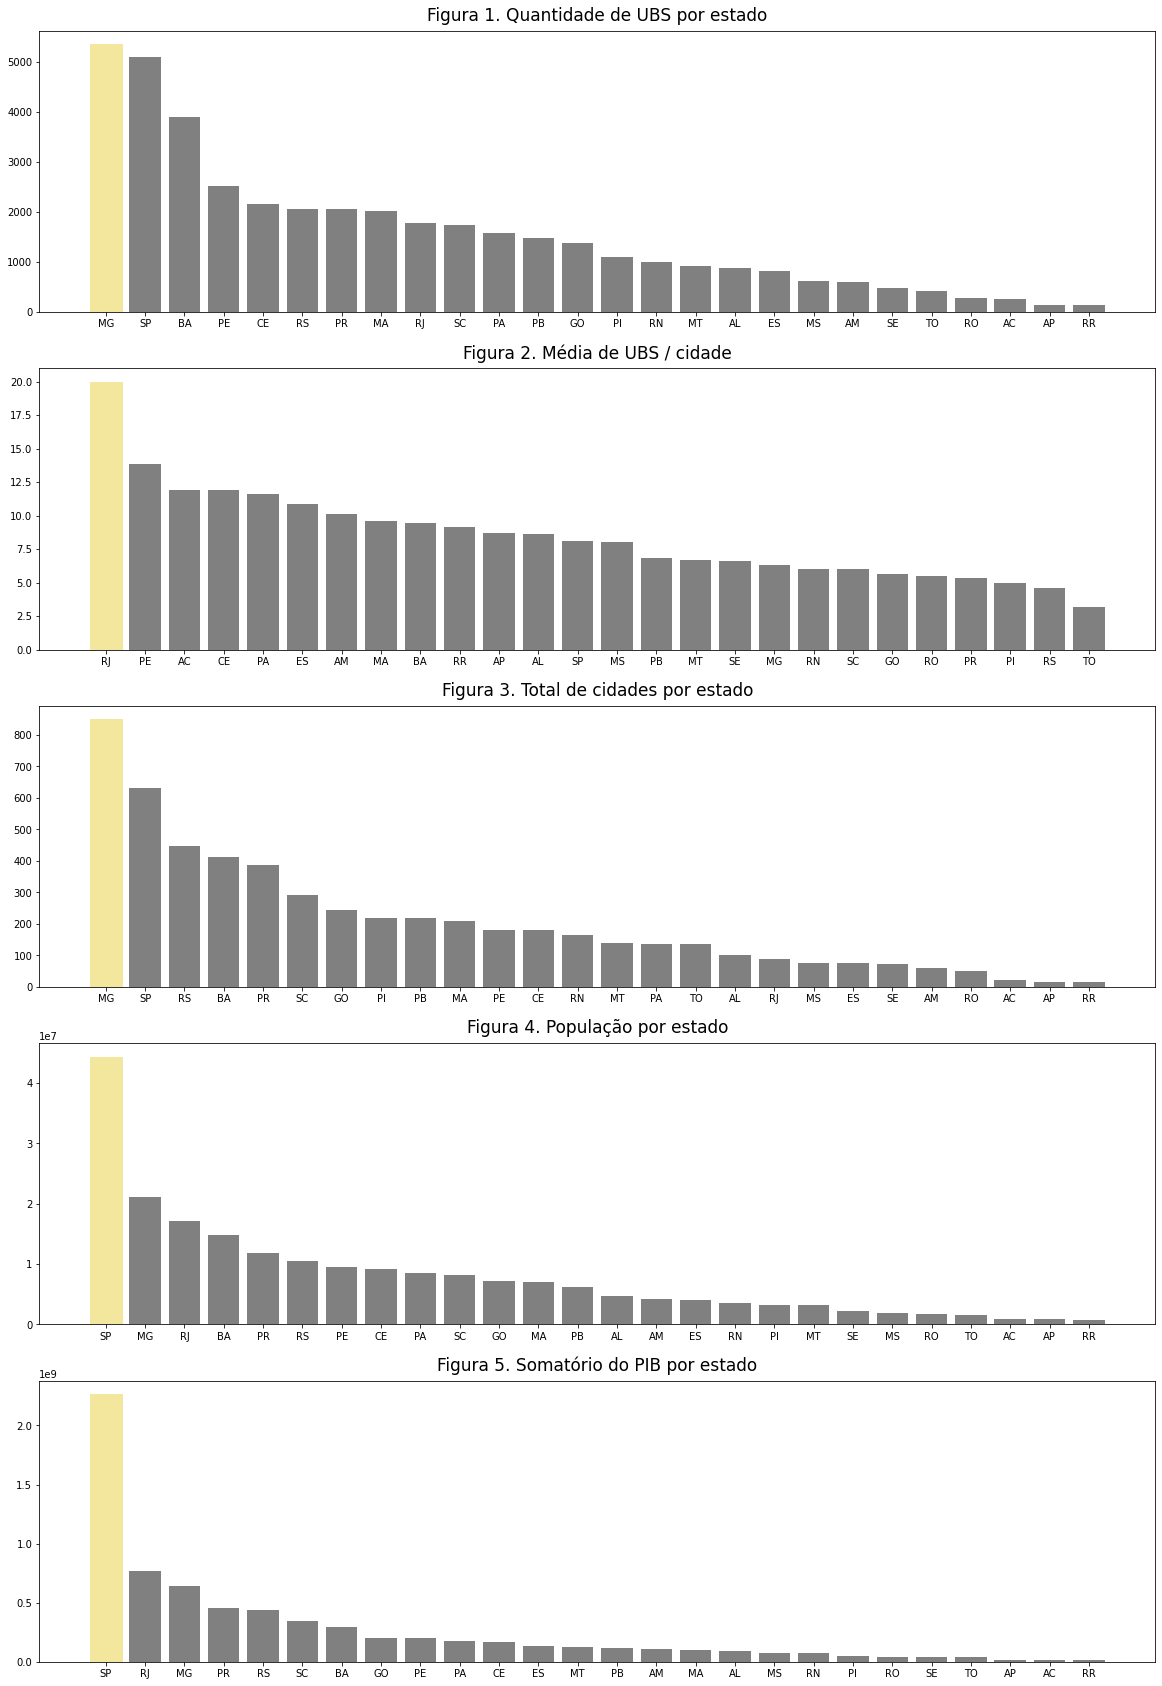

In [3]:
def view_distribution():
    # Carrega dataset e variáveis para plot
    dataset = get_dataset()
    x_ubs, y_ubs = [], []
    x_pop, y_pop = [], []
    x_pib, y_pib = [], []
    x_rel, y_rel = [], []
    x_cit, y_cit = [], []

    # Calcula a quantidade de UBS em cada estado
    serie = dataset["UF"].value_counts()
    for index in serie.index:
        x_ubs.append(index)
        y_ubs.append(serie[index])
    sort_with_category(x_ubs, y_ubs)

    # Calcula a média de UBS / Cidade em cada estado
    for index in serie.index:
        cities = len(dataset.query(f"UF == '{index}'")["CITY"].unique())
        x_rel.append(index)
        y_rel.append(serie[index] / cities if cities != 0 else 0)
    sort_with_category(x_rel, y_rel)

    # Calcula a quantidade de cidades em cada estado
    for index in serie.index:
        cities = len(dataset.query(f"UF == '{index}'")["CITY"].unique())
        x_cit.append(index)
        y_cit.append(cities)
    sort_with_category(x_cit, y_cit)

    # Calcula a quantidade de pessoas em cada estado e o PIB
    group = dataset.groupby(["CITY", "UF"])[[
        "POPULATION_2021", "PIB_2019"
    ]].agg("mean").groupby("UF").agg("sum")

    for index in group["POPULATION_2021"].index:
        x_pop.append(index)
        y_pop.append(group["POPULATION_2021"][index])
    sort_with_category(x_pop, y_pop)

    for index in group["PIB_2019"].index:
        x_pib.append(index)
        y_pib.append(group["PIB_2019"][index])
    sort_with_category(x_pib, y_pib)

    # Faz a exibição dos gráficos para visualização
    data = [
        {"title": "Figura 1. Quantidade de UBS por estado", "categories": x_ubs, "values": y_ubs},
        {"title": "Figura 2. Média de UBS / cidade", "categories": x_rel, "values": y_rel},
        {"title": "Figura 3. Total de cidades por estado", "categories": x_cit, "values": y_cit},
        {"title": "Figura 4. População por estado", "categories": x_pop, "values": y_pop},
        {"title": "Figura 5. Somatório do PIB por estado", "categories": x_pib, "values": y_pib}
    ]

    fig, ax = plt.subplots(len(data), 1, figsize=(20, 30))
    for i in range(0, len(data)):
        category_number = [j for j in range(len(data[i]["categories"]))]
        chart = ax[i].bar(category_number, data[i]["values"], color=get_color("black"))
        ax[i].set_xticks(category_number, labels=data[i]["categories"], fontsize=10)
        ax[i].set_title(data[i]["title"], pad=10, fontdict={"fontsize": 17})
        chart[0].set_color(get_color("focus"))
    
    plt.show()


view_distribution()

Duas abordagens podem ser realizadas para coeficiente de correlação. A primeira visa agrupar por cidade, verificando se existem indícios de relação entre quantidade de UBS, área, população e distância da unidade até o centro da cidade. O resultado desta análise aponta para uma correlação forte (~0,80) entre população e quantidade de UBS. Ou seja, dentro de uma cidade, possivelmente o número de pessoas exerce certa influência sobre o número de UBS.

A próxima abordagem é utilizando um agrupamento por estado. Esta resulta em um espaço amostral pequeno (26 estados brasileiros), não muito ideal para os cálculos. Todavia, ainda pode ser utilizada como uma forma de "ilustração" e para fornecer uma tradução numérica para a análise visual feita anteriormente. E o resultado corrobora para a fortíssima correlação (~0,9) entre número de cidades e quantidade de UBS. Nesta visão a população também apresenta forte correlação (~0,80), o que remove a dúvida lançada pela análise gráfica, de que a população influenciaria pouco na alocação de UBS nos estados e municípios.

Também é interessante comentar sobre a distância das UBS até o centro da cidade. Esperava-se que em cidades maiores esta distância também fosse acentuada, uma vez que deveriam de existir mais unidades em locais periféricos. Porém, na abordagem por cidade a distância e a área não demonstram indícios de correlação. Na abordagem por estado, a distância apresenta uma correlação de leve para moderada com a quantidade de UBS e número de cidades, ambas negativas.

In [4]:
def show_corr():
    # Carrega dataset
    dataset = get_dataset()
    data = []
    for city in dataset["CITY"].unique():
        subset = dataset.query(f"CITY == '{city}'")
        data.append({
            "UBS": len(subset),
            "AREA": np.mean(subset["AREA"].values),
            "DISTANCE": np.mean(subset["DISTANCE"].values),
            "POPULATION": np.mean(subset["POPULATION_2021"].values)
        })
    print(pd.DataFrame(data).corr())

    data = []
    for uf in dataset["UF"].unique():
        subset = dataset.query(f"UF == '{uf}'")
        group = subset.groupby("CITY")[[
            "DISTANCE", "AREA", "POPULATION_2021"
        ]].agg("mean")
        data.append({
            "UBS": len(subset),
            "CITIES": len(subset["CITY"].unique()),
            "DISTANCE": np.mean(group["DISTANCE"].values),
            "AREA": np.sum(group["AREA"].values),
            "POPULATION": np.sum(group["POPULATION_2021"].values)
        })
    print("\n")
    print(pd.DataFrame(data).corr())


show_corr()

                 UBS      AREA  DISTANCE  POPULATION
UBS         1.000000  0.045078  0.087238    0.833173
AREA        0.045078  1.000000  0.180348    0.016873
DISTANCE    0.087238  0.180348  1.000000    0.044439
POPULATION  0.833173  0.016873  0.044439    1.000000


                 UBS    CITIES  DISTANCE      AREA  POPULATION
UBS         1.000000  0.913130 -0.445146  0.092355    0.873425
CITIES      0.913130  1.000000 -0.508210  0.080917    0.760896
DISTANCE   -0.445146 -0.508210  1.000000  0.192039   -0.386078
AREA        0.092355  0.080917  0.192039  1.000000    0.037687
POPULATION  0.873425  0.760896 -0.386078  0.037687    1.000000


Avaliando as distâncias, dois estados apresentam uma descrição peculiar, principalmente na magnitude que a distância do centro da cidade até uma UBS pode atingir. Os estados de SC e MS possuem UBS que se distanciam de até 270km e 330km do centro, respectivamente.

In [33]:
def view_distances():
    # Organiza informações sobre as distâncias das UBS até o centro da cidade
    dataset = get_dataset()
    group = dataset.groupby(["CITY", "UF"])["DISTANCE"].agg([
        "mean", "count"
    ]).groupby("UF").agg({
        "count": "sum",
        "mean": ["min", "mean", "median", "max"]
    }, axis=1).sort_values(("count", "sum"), ascending=False)

    # Exibe dados descritivos para distâncias
    print(f"Distância média no Brasil: {round(np.mean(group['mean'].values), 2)}")
    print()
    print(group)


view_distances()

Distância média no Brasil: 18.81

   count      mean                                  
     sum       min       mean     median         max
UF                                                  
MG  5357  0.000000   2.640581   1.219120   43.073690
SP  5111  0.139705   2.515550   1.417374   48.081876
BA  3897  0.089656   5.299528   2.998163   44.719465
PE  2524  0.111120   3.359974   2.139746   18.907507
CE  2155  0.175642   5.423790   3.950490   35.611926
RS  2067  0.000000   2.670164   1.231042   41.707372
PR  2054  0.000000   3.308781   1.350572   66.803025
MA  2031  0.156538   6.135093   3.749348   71.228899
RJ  1780  0.248472   4.988176   3.830007   22.362471
SC  1748  0.157147   3.514402   1.368939  276.588372
PA  1588  0.496944  10.457167   7.208813   64.771429
PB  1493  0.222240   3.073279   1.266480   88.029101
GO  1385  0.000000   2.994527   1.271962   34.752307
PI  1100  0.209970   4.397357   1.276525   48.886116
RN   999  0.163076   3.708691   1.539455   78.446628
MT   928  0.